# Microgan for NASA Space Apps Challenge
The following lines of code represent the training and image generation process for Team Nepali Ho Ni at NASA Space Apps Challenge 2022. To run the entire code, it will take about 8-20 hours in a powerful machine + you will need to get the data from kaggle(jupiter-juno-mission-image-set-nasa) as it is too large to be put on github.

The pretrained model is also included as gen.pt so it is possible to just use the generator model to generate images yourself, though it would still be heavy on your computer resources. The example to generate images and store them using the pretrained model is shown just before the training process for your ease and convinience.

As long as you are not trying to re train the model from scratch, you can run every cells, do mind to ignore the errors and still able to run the mustyle gan because all the components are available. Be sure to have all python libraries in requirements.txt installed in your python environment.

**Best wishes 
Keep coding**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()


In [2]:
os.listdir('../input/jupiter-juno-mission-image-set-nasa/JUPITER')

['RADIATION_TREND_MONITORING',
 'APPROACH_MOV_I',
 'EARTH_FLYBY',
 'RDR_ORBIT',
 'RDR_POSITIVE_MAIN',
 'SOUTH_POLE_MINIMUM_EMISSION_ANGLE',
 'APPROACH_RAW_IMAGE',
 'SOUTHERN_TIMELAPSE_SEQUENCE',
 'LATITUDE_COVERAGE']

In [3]:
from scipy.stats import truncnorm
def get_truncated_noise(n_samples, z_dim, truncation):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    '''
    #### START CODE HERE ####
    truncated_noise = truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim))
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

In [4]:
class MappingLayers(nn.Module):
    '''
    Mapping Layers Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        hidden_dim: the inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''
 
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            # shape (n_samples, z_dim) and outputs (n_samples, w_dim)
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,w_dim)
        )

    def forward(self, noise):
        '''
        Function for completing a forward pass of MappingLayers: 
        Given an initial noise tensor, returns the intermediate noise tensor.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.mapping(noise)
    
    def get_mapping(self):
        return self.mapping

In [5]:

class InjectNoise(nn.Module):
    '''
    Inject Noise Class
    Values:
        channels: the number of channels the image has, a scalar
    '''
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter( 
            # nn.Parameter so that these weights can be optimized
            # Initiate the weights for the channels from a random normal distribution
            torch.randn(1, channels, 1, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of InjectNoise: Given an image, 
        returns the image with random noise added.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
        '''
        # Set the appropriate shape for the noise!
        
        noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3])
        
        noise = torch.randn(noise_shape, device=image.device) # Creates the random noise
        return image + self.weight * noise # Applies to image after multiplying by the weight for each channel
    
    def get_weight(self):
        return self.weight
    
    def get_self(self):
        return self

In [6]:
class AdaIN(nn.Module):
    '''
    AdaIN Class
    Values:
        channels: the number of channels the image has, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''

    def __init__(self, channels, w_dim):
        super().__init__()

        # Normalize the input per-dimension
        self.instance_norm = nn.InstanceNorm2d(channels)

        # to map w to a set of style weights per channel.
        #  correct dimensions - keep in mind that 
        # both linear maps transform a w vector into style weights 
        # corresponding to the number of image channels.
        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)

    def forward(self, image, w):
        '''
        Function for completing a forward pass of AdaIN: Given an image and intermediate noise vector w, 
        returns the normalized image that has been scaled and shifted by the style.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]
        
        # Calculate the transformed image
        transformed_image = style_scale * normalized_image + style_shift
        return transformed_image
    
    def get_style_scale_transform(self):
        return self.style_scale_transform
    
    def get_style_shift_transform(self):
        return self.style_shift_transform
    
    def get_self(self):
        return self 


In [7]:

class MicroStyleGANGeneratorBlock(nn.Module):
    '''
    Micro StyleGAN Generator Block Class
    Values:
        in_chan: the number of channels in the input, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        kernel_size: the size of the convolving kernel
        starting_size: the size of the starting image
    '''

    def __init__(self, in_chan, out_chan, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample = use_upsample
        # 1. Upsample to the starting_size, bilinearly (https://pytorch.org/docs/master/generated/torch.nn.Upsample.html)
        # 2. Create a kernel_size convolution which takes in 
        #    an image with in_chan and outputs one with out_chan (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
        # 3. Create an object to inject noise
        # 4. Create an AdaIN object
        # 5. Create a LeakyReLU activation with slope 0.2
        
        if self.use_upsample:
            self.upsample = nn.Upsample((starting_size), mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1) # Padding is used to maintain the image size
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        '''
        Function for completing a forward pass of MicroStyleGANGeneratorBlock: Given an x and w, 
        computes a StyleGAN generator block.
        Parameters:
            x: the input into the generator, feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.activation(x)
        x = self.adain(x, w)
        return x
    
    def get_self(self):
        return self;

In [8]:
class MicroStyleGANGenerator(nn.Module):
    '''
    Micro StyleGAN Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        map_hidden_dim: the mapping inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        in_chan: the dimension of the constant input, usually w_dim, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        kernel_size: the size of the convolving kernel
        hidden_chan: the inner dimension, a scalar
    '''

    def __init__(self, 
                 z_dim, 
                 map_hidden_dim,
                 w_dim,
                 in_chan,
                 out_chan, 
                 kernel_size, 
                 hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        # Gaussian to better visualize the network's effect
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 9, 30))
        self.block0 = MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)
        self.block1 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, (36,120))
        self.block2 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, (90,300))
        # You need to have a way of mapping from the output noise to an image, 
        # so you learn a 1x1 convolution to transform the e.g. 512 channels into 3 channels
        # (Note that this is simplified, with clipping used in the real StyleGAN)
        self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.alpha = 0.2

    def upsample_to_match_size(self, smaller_image, bigger_image):
        '''
        Function for upsampling an image to the size of another: Given a two images (smaller and bigger), 
        upsamples the first to have the same dimensions as the second.
        Parameters:
            smaller_image: the smaller image to upsample
            bigger_image: the bigger image whose dimensions will be upsampled to
        '''
        return F.interpolate(smaller_image, size=bigger_image.shape[-2:], mode='bilinear')

    def forward(self, noise, return_intermediate=False):
        '''
        Function for completing a forward pass of MicroStyleGANGenerator: Given noise, 
        computes a StyleGAN iteration.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
            return_intermediate: a boolean, true to return the images as well (for testing) and false otherwise
        '''
        x = self.starting_constant
        w = self.map(noise)
        x = self.block0(x, w)
        x_small = self.block1(x, w) # First generator run output
        x_small_image = self.block1_to_image(x_small)
        x_big = self.block2(x_small, w) # Second generator run output 
        x_big_image = self.block2_to_image(x_big)
        x_small_upsample = self.upsample_to_match_size(x_small_image, x_big_image) # Upsample first generator run output to 
#         be same size as second generator run output 
        # Interpolate between the upsampled image and the image from the generator using alpha
        
        interpolation = torch.lerp(x_small_upsample,x_big_image,self.alpha)
        
        if return_intermediate:
            return interpolation, x_small_upsample, x_big_image
        return interpolation
    
    def get_self(self):
        return self;

In [9]:
class AttentionBlock(nn.Module):
    '''
    AttentionBlock Class
    Values:
    channels: number of channels in input
    '''
    def __init__(self, channels):
        super().__init__()

        self.channels = channels

        self.theta = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.phi = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.g = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 2, kernel_size=1, padding=0, bias=False))
        self.o = nn.utils.spectral_norm(nn.Conv2d(channels // 2, channels, kernel_size=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        spatial_size = x.shape[2] * x.shape[3]

        # Apply convolutions to get query (theta), key (phi), and value (g) transforms
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        # Reshape spatial size for self-attention
        theta = theta.view(-1, self.channels // 8, spatial_size)
        phi = phi.view(-1, self.channels // 8, spatial_size // 4)
        g = g.view(-1, self.channels // 2, spatial_size // 4)

        # Compute dot product attention with query (theta) and key (phi) matrices
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), dim=-1)

        # Compute scaled dot product attention with value (g) and attention (beta) matrices
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        # Apply gain and residual
        return self.gamma * o + x

In [10]:
class DResidualBlock(nn.Module):
    '''
    DResidualBlock Class
    Values:
    in_channels: the number of channels in the input, a scalar
    out_channels: the number of channels in the output, a scalar
    downsample: whether to apply downsampling
    use_preactivation: whether to apply an activation function before the first convolution
    '''

    def __init__(self, in_channels, out_channels, downsample=True, use_preactivation=False):
        super().__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        self.activation = nn.ReLU()
        self.use_preactivation = use_preactivation  # apply preactivation in all except first dblock

        self.downsample = downsample    # downsample occurs in all except last dblock
        if downsample:
            self.downsample_fn = nn.AvgPool2d(2)
        self.mixin = (in_channels != out_channels) or downsample
        if self.mixin:
            self.conv_mixin = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0))

    def _residual(self, x):
        if self.use_preactivation:
            if self.mixin:
                x = self.conv_mixin(x)
            if self.downsample:
                x = self.downsample_fn(x)
        else:
            if self.downsample:
                x = self.downsample_fn(x)
            if self.mixin:
                x = self.conv_mixin(x)
        return x

    def forward(self, x):
        # Apply preactivation if applicable
        if self.use_preactivation:
            h = F.relu(x)
        else:
            h = x

        h = self.conv1(h)
        h = self.activation(h)
        if self.downsample:
            h = self.downsample_fn(h)

        return h + self._residual(x)

In [11]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    base_channels: the number of base channels, a scalar
    n_classes: the number of image classes, a scalar
    '''

    def __init__(self, base_channels=96, n_classes=1000):
        super().__init__()

        # For adding class-conditional evidence
        self.shared_emb = nn.utils.spectral_norm(nn.Embedding(n_classes, 16 * base_channels))

        self.d_blocks = nn.Sequential(
            DResidualBlock(3, base_channels, downsample=True, use_preactivation=False),
#             AttentionBlock(base_channels),

            DResidualBlock(base_channels, 2 * base_channels, downsample=True, use_preactivation=True),
#             AttentionBlock(2 * base_channels),

            DResidualBlock(2 * base_channels, 4 * base_channels, downsample=True, use_preactivation=True),
#             AttentionBlock(4 * base_channels),

            DResidualBlock(4 * base_channels, 8 * base_channels, downsample=True, use_preactivation=True),
#             AttentionBlock(8 * base_channels),

            DResidualBlock(8 * base_channels, 16 * base_channels, downsample=True, use_preactivation=True),
#             AttentionBlock(16 * base_channels),

            DResidualBlock(16 * base_channels, 16 * base_channels, downsample=False, use_preactivation=True),
#             AttentionBlock(16 * base_channels),

            nn.ReLU(inplace=True),
        )
        self.proj_o = nn.utils.spectral_norm(nn.Linear(16 * base_channels, 1))

    def forward(self, x, y=None):
        h = self.d_blocks(x)
        h = torch.sum(h, dim=[2, 3])

        # Class-unconditional output
        uncond_out = self.proj_o(h)
        if y is None:
            return uncond_out

        # Class-conditional output
        cond_out = torch.sum(self.shared_emb(y) * h, dim=1, keepdim=True)
        return uncond_out + cond_out

In [12]:
images = os.listdir('../input/jupiter-juno-mission-image-set-nasa/JUPITER/RDR_ORBIT')

In [13]:
class customdataset(Dataset):
    def __init__(self, images):
        self.transform = T.Compose([
                                T.ToTensor(),
                                T.Resize((90,300))
                                    ])
        self.data = [cv2.cvtColor(cv2.imread('../input/jupiter-juno-mission-image-set-nasa/JUPITER/RDR_ORBIT/'+img),cv2.COLOR_BGR2RGB) for img in images]
    def __getitem__(self, index):
        return  self.transform(self.data[index]) 

    def __len__(self):
        return len(self.data)

In [14]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(d,device) for d in data]
    return data.to(device,non_blocking = True)

In [15]:
class DeviceDL():
    
    def __init__(self,dl,dev):
        self.dl = dl
        self.dev = dev
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch,self.dev)
            
    def __len__(self):
        return len(self.dl)

In [16]:
batch_size = 16

In [18]:
DS =angle_spectrum customdataset(images)
DL = DataLoader(DS,batch_size=batch_size)
DL = DeviceDL(DL,device)

In [19]:
len(DS)

NameError: name 'DS' is not defined

In [21]:
# plt.imshow(DS[11].permute(1,2,0))

In [22]:
z_dim = 128
out_chan = 3
truncation = 0.7
lr = 0.0002
beta_1, beta_2 = (0.0, 0.999)

criterion = nn.BCEWithLogitsLoss()
gen = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=512,
    w_dim=256,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
).to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, beta_2))
disc  = Discriminator(base_channels=96, n_classes=1).to(device)

disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

mu_stylegan = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=512,
    w_dim=256,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
).to(device)

In [23]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [24]:
random_sample = DS[0]

NameError: name 'DS' is not defined

In [ ]:
random_sample.size()

In [ ]:
# viz_samples = 10
# The noise is exaggerated for visual effect
# viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

# images = []
# for alpha in np.linspace(0, 1, num=5):
#     mu_stylegan.alpha = alpha
#     viz_result, _, _ =  mu_stylegan(
#         viz_noise, 
#         return_intermediate=True)
#     images += [tensor for tensor in viz_result]
# show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
# mu_stylegan = mu_stylegan.train()

In [25]:
mu_stylegan.load_state_dict(torch.load('../input/pretrained-generator/gen.pt'))
mu_stylegan.eval()

MicroStyleGANGenerator(
  (map): MappingLayers(
    (mapping): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (block0): MicroStyleGANGeneratorBlock(
    (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (inject_noise): InjectNoise()
    (adain): AdaIN(
      (instance_norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (style_scale_transform): Linear(in_features=256, out_features=256, bias=True)
      (style_shift_transform): Linear(in_features=256, out_features=256, bias=True)
    )
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (block1): MicroStyleGANGeneratorBlock(
    (upsample): Upsample(size=(36, 120), mode=bilinear)
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [26]:
noise = get_truncated_noise(64, z_dim, truncation).to(device)

In [27]:
images=mu_stylegan(noise).permute(0,2,3,1).detach().to('cpu').numpy()

In [28]:
images.shape

(64, 90, 300, 3)

In [29]:
images[0].shape

(90, 300, 3)

In [30]:
random = Image.fromarray((images[15]*255).astype(np.uint8))

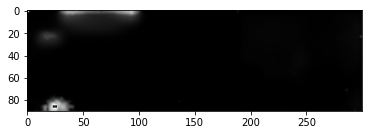

In [31]:
plt.imshow(random)

In [ ]:
# !rm -rf images

In [45]:
!mkdir images

In [46]:
for i in range(len(images)):
    cur_im = images[i]
    img = Image.fromarray((cur_im*255).astype(np.uint8)).convert('RGB')

    img.save(f'./images/{i}.png')

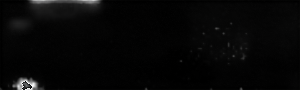

In [44]:
img

In [67]:
# !zip -r img.zip images

  adding: images/ (stored 0%)
  adding: images/3.png (stored 0%)
  adding: images/42.png (stored 0%)
  adding: images/43.png (stored 0%)
  adding: images/47.png (stored 0%)
  adding: images/9.png (stored 0%)
  adding: images/37.png (stored 0%)
  adding: images/26.png (stored 0%)
  adding: images/32.png (stored 0%)
  adding: images/33.png (stored 0%)
  adding: images/25.png (stored 0%)
  adding: images/51.png (stored 0%)
  adding: images/58.png (stored 0%)
  adding: images/35.png (stored 0%)
  adding: images/31.png (stored 0%)
  adding: images/12.png (stored 0%)
  adding: images/45.png (stored 0%)
  adding: images/60.png (stored 0%)
  adding: images/13.png (stored 0%)
  adding: images/2.png (stored 0%)
  adding: images/29.png (stored 0%)
  adding: images/57.png (stored 0%)
  adding: images/23.png (stored 0%)
  adding: images/41.png (stored 0%)
  adding: images/30.png (stored 0%)
  adding: images/11.png (stored 0%)
  adding: images/54.png (stored 0%)
  adding: images/6.png (stored 0%)
  

In [36]:
cv2.imread('../input/jupiter-juno-mission-image-set-nasa/JUPITER/RDR_ORBIT/JIR_IMG_RDR_2017296T232258_V01.png').shape

(128, 432, 3)

# **only use the following block of code to train!!!!**
The training process on a well eqquiped graphics card would take around 8-16 hours. To view the results you can just see the mustylegan above which is pretrained

In [ ]:
n_epochs = 70
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
display_step = 500

for epoch in range(n_epochs):
    for real in DL:
        cur_batch_size = len(real)
        real = real
        disc_opt.zero_grad()
        fake_noise = get_truncated_noise(cur_batch_size, z_dim, truncation).to(device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()
        
        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_truncated_noise(cur_batch_size, z_dim, truncation).to(device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [ ]:
torch.save(gen.state_dict(), 'gen.pt')


In [ ]:
gen.eval()

In [ ]:
noise = get_truncated_noise(64, z_dim, truncation).to(device)

In [ ]:
del disc

In [ ]:
images=gen(noise).detach().to('cpu').numpy()

In [ ]:
images.size()

In [ ]:
plt.imshow(images[12].permute(1,2,0))